In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import copy

import factor_analyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from factor_analyzer import FactorAnalyzer
from scipy.stats import bartlett # 目前有问题

import sklearn
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.preprocessing import StandardScaler

import statsmodels
from statsmodels.multivariate.factor import Factor, FactorResults

# import factanal
# from factanal.wrapper import factanal # 运行该包会导致jupyter内核报错。可能是因为rpy2不支持在windows上运行。

os.chdir('H:/I.R/Project：Neuroscience/Data Science Training')
pd.set_option('display.float_format',lambda x : '%.3f' % x)
np.set_printoptions(suppress=True)

In [2]:
input_path = './Training dataset/EFA+CFA/FactorAnalysis.csv'
data = pd.read_csv(input_path)
variable_names = data.columns
data.head(6)

,Academic record,Appearance,Communication,Company Fit,Experience,Job Fit,Letter,Likeability,Organization,Potential,Resume,Self-Confidence
0,6,8,7,5,6,5,7,7,7,6,7,7
1,9,8,8,8,10,9,8,9,8,9,9,9
2,6,7,7,6,6,7,7,8,8,6,6,8
3,7,8,6,5,8,5,9,8,7,8,7,7
4,4,7,8,6,6,6,6,7,8,5,4,6
5,7,7,7,5,5,6,5,7,8,7,4,6


In [23]:
data.iloc[0]

Academic record    6
Appearance         8
Communication      7
Company Fit        5
Experience         6
Job Fit            5
Letter             7
Likeability        7
Organization       7
Potential          6
Resume             7
Self-Confidence    7
Name: 0, dtype: int64

In [3]:
Zdata = pd.DataFrame(StandardScaler().fit_transform(data))
corrcoef = pd.DataFrame(np.corrcoef(Zdata.T))
corr = copy.deepcopy(corrcoef)

In [31]:
def kmo(dataset_corr):
    import numpy as np
    import math
    corr_inv = np.linalg.inv(dataset_corr)
    nrow_inv_corr, ncol_inv_corr = dataset_corr.shape
    A = np.ones((nrow_inv_corr, ncol_inv_corr))
    for i in range(0, nrow_inv_corr, 1):
        for j in range(i, ncol_inv_corr, 1):
            A[i, j] = -(corr_inv[i, j]) / (math.sqrt(corr_inv[i, i] * corr_inv[j, j]))
            A[j, i] = A[i, j]
    dataset_corr = np.asarray(dataset_corr)
    kmo_num = np.sum(np.square(dataset_corr)) - np.sum(np.square(np.diagonal(A)))
    kmo_denom = kmo_num + np.sum(np.square(A)) - np.sum(np.square(np.diagonal(A)))
    kmo_value = kmo_num / kmo_denom
    return kmo_value

In [32]:
corrcoef.columns = variable_names
corrcoef.index = variable_names
print("KMO with self-made function:", kmo(corrcoef))
print("KMO with FA package:", calculate_kmo(Zdata)[1])
BartlettStats, BartlettPValue = format(calculate_bartlett_sphericity(Zdata)[0], 'f'), format(calculate_bartlett_sphericity(Zdata)[1], 'f')
print("Bartlett test with FA package: statistics =", BartlettStats, ", p-value =", BartlettPValue)
BartlettStats2, BartlettPValue2 = bartlett(Zdata[0], Zdata[1], Zdata[2], Zdata[3], Zdata[3], Zdata[4], Zdata[5], Zdata[6], Zdata[7], Zdata[8], Zdata[9], Zdata[10], Zdata[11])
print("Bartlett test with scipy package: statistics =", format(BartlettStats2, 'f'), ", p-value =", BartlettPValue2, ". now we have some issues.")

KMO with self-made function: 0.7979087431160236
KMO with FA package: 0.7979087431160238
Bartlett test with FA package: statistics = 472.514673 , p-value = 0.000000
Bartlett test with scipy package: statistics = 0.000000 , p-value = 1.0 . now we have some issues.


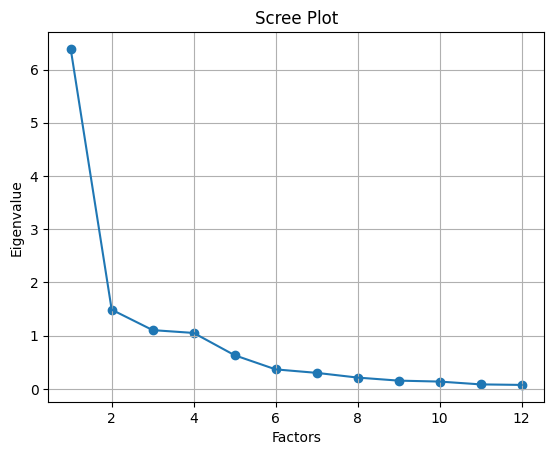

In [38]:
# scree plot
fa = FactorAnalyzer(n_factors = 12, rotation = None)
fa.fit(Zdata)
ev, v = fa.get_eigenvalues()

plt.scatter(range(1,Zdata.shape[1]+1),ev)
plt.plot(range(1,Zdata.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

用的FA包做初步拟合。特征值提示我们大约**4**个因子比较合适。

In [7]:
# variance explained
variance, prop_vari, cum_vari_efa = fa.get_factor_variance()
cum_vari_efa = pd.DataFrame(cum_vari_efa)
cum_vari_efa.index = ["factor1", "factor2", "factor3", "factor4", "factor5", "factor6", "factor7", "factor8", "factor9", "factor10", "factor11", "factor12"]
cum_vari_efa.columns = ["cumulative variances"]
print("Cumulative Prop. Variance Explained: ")
cum_vari_efa

Cumulative Prop. Variance Explained: 


,cumulative variances
factor1,0.523
factor2,0.638
factor3,0.723
factor4,0.802
factor5,0.846
factor6,0.865
factor7,0.876
factor8,0.883
factor9,0.889
factor10,0.891


看一眼方差解释比例。4个解释了80%，还可以，能接受，就4个了。

In [8]:
# EFA with factor_analyzer。本包改自R包psych:fa()
fa = FactorAnalyzer(n_factors = 4,
                    rotation = "varimax", # 希望是正交旋转
                    method = "principal", # 三种方法分别是MINRES最小残差/OLS/ULS最小二乘、最大似然和主轴分解（迭代主成分因子分析）。最后一种待定，有文献指出“可能是”。
                    use_smc = True, # 默认值
                    )
fa.fit(Zdata) # 由于数据已经预处理过了，相当于SPSS的根据相关性矩阵进行分析
loadings = pd.DataFrame(fa.loadings_, columns = ["factor1", "factor2", "factor3", "factor4"], index = variable_names)
loadings = loadings.sort_values(by = "factor1", ascending = False)
print('Factor Loadings after rotation \n%s' %loadings)


Factor Loadings after rotation 
                 factor1  factor2  factor3  factor4
Potential          0.839    0.284    0.116    0.286
Experience         0.813   -0.059    0.353    0.160
Academic record    0.801    0.175    0.122    0.265
Job Fit            0.622    0.597    0.197    0.143
Company Fit        0.510    0.723    0.178    0.127
Self-Confidence    0.273    0.197    0.076    0.849
Resume             0.270    0.133    0.857    0.319
Appearance         0.208    0.242    0.170    0.804
Letter             0.207    0.249    0.914    0.061
Likeability        0.198    0.310    0.186    0.772
Communication      0.069    0.822    0.216    0.311
Organization       0.067    0.849    0.082    0.372


In [ ]:
# EFA with sklearn 目前看来是个大坑，没有找到好的方案调出
fa2 = FactorAnalysis(
    n_components = 4,
    rotation = "varimax" # 不是很友好，只有varimax和quartimax，都是正交。因子提取方法只有最大似然。
    )
fa2.fit()
# fa2.components_ # 目前不太清楚这部分数据是什么。原文为Components with maximum variance，最大方差的组件，理论上应该是成分矩阵，但是和其他包做出来的完全不一样。怀疑在参数输入的地方可能有问题。
# fa2.get_feature_names_out

In [ ]:
# EFA with statsmodels
fa3 = Factor()

In [ ]:
# EFA with factanal(wrapper)
# https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/factanal
# fa4 = factanal(Zdata, factors = 4, scores = None, rotation = "varimax") # 该函数是R函数的api，输入的文件只支持pandas的dataframe，不支持最大似然。
# 使用该包需要拥有R语言和rpy2。rpy2则不支持在windows上运行，因此该方法无用。

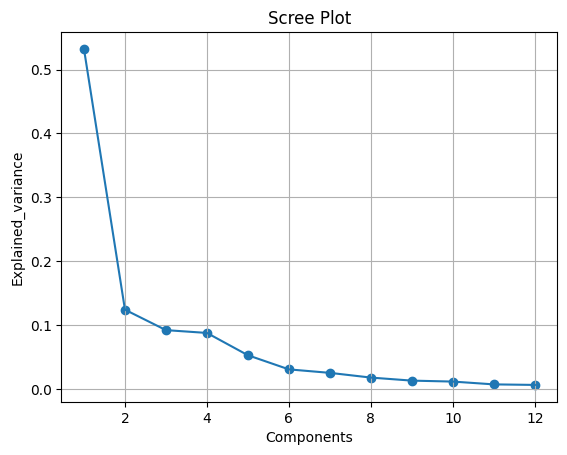

In [11]:
# PCA with sklearn 1
pca = PCA(n_components = 12).fit(Zdata)
cum_vari_pca = pca.explained_variance_ratio_
plt.scatter(range(1,Zdata.shape[1]+1),cum_vari_pca)
plt.plot(range(1,Zdata.shape[1]+1),cum_vari_pca)
plt.title('Scree Plot')
plt.xlabel('Components')
plt.ylabel('Explained_variance')
plt.grid()
plt.show()


In [28]:
# PCA with sklearn 2
pca = PCA(n_components = 4).fit(Zdata)
k1_spss = pd.DataFrame(pca.components_ / np.sqrt(pca.explained_variance_.reshape(pca.n_components_, 1))).T
k1_spss.columns = ['Component1', 'Component2', 'Component3', 'Component4']
k1_spss.index = [1,2,3,4,5,6,7,8,9,10,11,12]
print('贡献方差，即特征根: ', pca.explained_variance_)
print('方差贡献率: ', pca.explained_variance_ratio_)
print("成分得分系数矩阵: ")
k1_spss

贡献方差，即特征根:  [6.51800387 1.51884155 1.12701845 1.07310726]
方差贡献率:  [0.53230365 0.12403873 0.09203984 0.08763709]
成分得分系数矩阵: 


,Component1,Component2,Component3,Component4
1,-0.113,-0.224,0.292,0.098
2,-0.111,0.180,0.146,-0.376
3,-0.110,0.297,-0.228,0.215
4,-0.124,0.040,-0.043,0.403
5,-0.100,-0.402,0.163,-0.035
6,-0.126,-0.052,0.026,0.344
7,-0.097,-0.217,-0.587,-0.126
8,-0.115,0.196,0.105,-0.325
9,-0.109,0.359,-0.125,0.232
10,-0.126,-0.193,0.292,0.157


In [32]:
# PCA with sklearn 3
x_score = pca.transform(Zdata)
# print('因子得分:', x_score)        # 因子得分归一化，使其服从正态分布
scaler2 = StandardScaler().fit(x_score)
X_score_scaler = pd.DataFrame(scaler2.transform(x_score), columns=['COMP1', 'COMP2', 'COMP3', 'COMP4']) #正负号转化
k_sign = np.sign(k1_spss.sum(axis=1)) # 取正负号
x_score_scaler_sign = X_score_scaler * k_sign # 综合得分
rate = pca.explained_variance_ratio_
x_score_scaler_sign[ 'FAC_score'] = np.sum(x_score_scaler_sign * rate,axis=1)
print('主成分得分矩阵:', x_score_scaler_sign)

ValueError: Unable to coerce to Series, length must be 16: given 4

In [ ]:
# CFA & SEM